# AdTracking Fraud Detection Challange

In [1]:
# Importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.cross_validation import train_test_split

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Importing data
dtypes = {'ip'            : 'uint32',
          'app'           : 'uint16',
          'device'        : 'uint16',
          'os'            : 'uint16',
          'channel'       : 'uint16',
          'is_attributed' : 'uint8',
          'click_id'      : 'uint32'
          } 
train = pd.read_csv('train_sample.csv', dtype=dtypes)
#test = pd.read_csv("test.csv", dtype=dtypes)
print(train.shape)
train.head()

(100000, 8)


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [3]:
# Check missing data
train.apply(lambda x: sum(x.isnull()))
# attributed_time is NaN when the app isn't downloaded after clicking on the ad
# https://www.kaggle.com/pranav84/xgboost-histogram-optimized-version/code
# ==> here they don't use 'attributed_time'. What do you think?

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
dtype: int64

In [4]:
# Unique values
train.apply(lambda x: len(x.unique()))

ip                 34857
app                  161
device               100
os                   130
channel              161
click_time         80350
attributed_time      228
is_attributed          2
dtype: int64

In [5]:
train.dtypes

ip                 uint32
app                uint16
device             uint16
os                 uint16
channel            uint16
click_time         object
attributed_time    object
is_attributed       uint8
dtype: object

In [6]:
# Extract day, hour and day of the week
train['hour'] = pd.to_datetime(train.click_time).dt.hour.astype('uint8')
train['day']  = pd.to_datetime(train.click_time).dt.day.astype('uint8')
train['dow']  = pd.to_datetime(train.click_time).dt.dayofweek.astype('uint8')

In [7]:
# # of clicks for each ip-day-hour combination
gp = train[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'qty'})
train = train.merge(gp, on=['ip','day','hour'], how='left')
del gp

In [8]:
# # of clicks for each ip-app combination
gp = train[['ip','app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
train = train.merge(gp, on=['ip','app'], how='left')
del gp

In [9]:
# Count the number of clicks by ip
ip_count = train.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']
train = pd.merge(train, ip_count, on='ip', how='left', sort=False)
train['clicks_by_ip'] = train['clicks_by_ip'].astype('uint16')

In [10]:
# Delete columns we don't need
train.drop(['ip'], axis=1, inplace=True)
train.drop(['day'], axis=1, inplace=True)
train.drop(['click_time'], axis=1, inplace=True)
train.drop(['attributed_time'], axis=1, inplace=True)

#change features to 'uint16'
train['qty'] = train['qty'].astype('uint16')
train['ip_app_count'] = train['ip_app_count'].astype('uint16')

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 10 columns):
app              100000 non-null uint16
device           100000 non-null uint16
os               100000 non-null uint16
channel          100000 non-null uint16
is_attributed    100000 non-null uint8
hour             100000 non-null uint8
dow              100000 non-null uint8
qty              100000 non-null uint16
ip_app_count     100000 non-null uint16
clicks_by_ip     100000 non-null uint16
dtypes: uint16(7), uint8(3)
memory usage: 2.4 MB


In [11]:
train.head()
#print(train[train['is_attributed'] != 0])

,app,device,os,channel,is_attributed,hour,dow,qty,ip_app_count,clicks_by_ip
0,12,1,13,497,0,9,1,1,3,8
1,25,1,17,259,0,13,1,4,4,149
2,12,1,19,212,0,18,1,1,1,2
3,13,1,13,477,0,4,1,1,1,3
4,12,1,1,178,0,9,3,1,2,4


In [12]:
X = train.drop('is_attributed', axis=1)
#y = pd.DataFrame(data=train['is_attributed'])
y = train['is_attributed']


print(X.shape, y.shape)

((100000, 9), (100000,))


In [13]:
# Gradient Boosting Machines
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

y_pred = gbrt.predict(X_test)
cm_gbrt = confusion_matrix(y_test, y_pred)

print('accuracy on training set: %f' % gbrt.score(X_train, y_train))
print('accuracy on test set: %f' % gbrt.score(X_test, y_test))
print(cm_gbrt)


accuracy on training set: 0.997733
accuracy on test set: 0.996600
[[24899    33]
 [   52    16]]


([<matplotlib.axis.XTick at 0x118829750>,
 <a list of 9 Text xticklabel objects>)

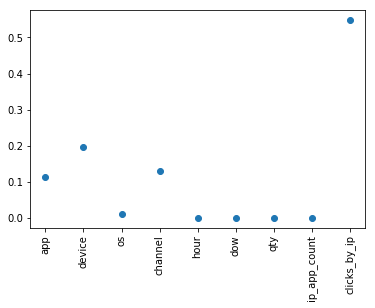

In [24]:
%matplotlib inline
plt.plot(gbrt.feature_importances_, 'o')
plt.xticks(range(X.shape[1]), X.columns.values, rotation=90)


In [37]:
# Light GBM
import lightgbm as lgb

d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 200
params['max_depth'] = 50
params['max_bin'] = 1000
params['categorical_feature'] = '0, 1, 2, 3, 4, 5'
clf = lgb.train(params, d_train, 10000)

In [38]:


#Prediction
y_pred = clf.predict(X_test)
#convert into binary values
for i in range(0, 25000):
    if y_pred[i]>=.5:       # setting threshold to .5
        y_pred[i]=1
    else:  
        y_pred[i]=0


In [41]:
    
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm_clf = confusion_matrix(y_test, y_pred)
print(cm_clf)
#Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred,y_test)
print('test: %f' % accuracy)

[[24913    19]
 [   43    25]]
test: 0.997520


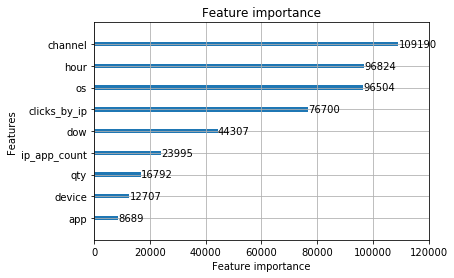

In [25]:
lgb.plot_importance(clf)

AttributeError: 'Booster' object has no attribute 'best_score_'